In [1]:
import pydotplus 
import pandas as pd

from IPython.display import Image
from sklearn import tree, grid_search
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

/home/daniel/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/daniel/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# %pylab inline

In [3]:
german = pd.read_csv('german_credit.csv', header=0, sep=',')

In [4]:
german.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex and Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [5]:
german_target = german.Creditability.values

german_data = german.iloc[:, 1:]

Доля класса 1

In [6]:
sum(german_target) / float(len(german_target))

0.69999999999999996

In [7]:
german_data.columns

Index(['Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex and Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')

Сделаем максимальную глубину дерева равной 2

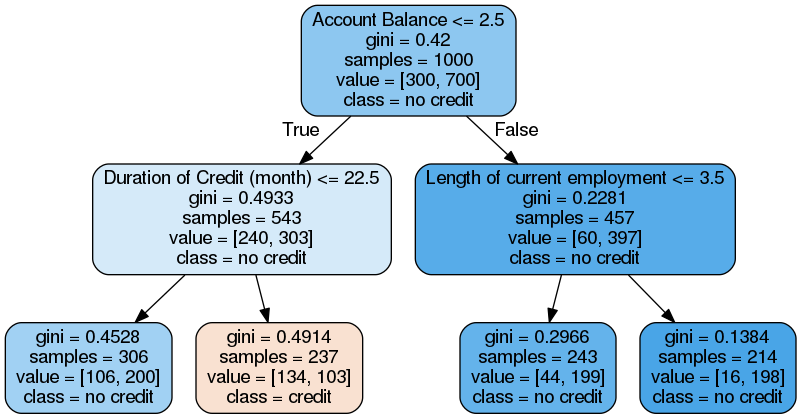

In [8]:
model = tree.DecisionTreeClassifier(max_depth=2)
model.fit(german_data, german_target)
dot_data = tree.export_graphviz(model, out_file="tree3.out", 
                         feature_names=german_data.columns,  
                         class_names=['credit', 'no credit'],  
                         filled=True, rounded=True,  
                         special_characters=False)  
graph = pydotplus.graphviz.graph_from_dot_file("tree3.out")  
Image(graph.create_png())

Заметим, что первыми параметрами, по которым происходят разбиения, являются Account Balance, Duration of Credits, Length of current employment. При получившимся решающем дереве кредит будет выдан только при Account Balance <= 2.5 и на небольшой срок (до 22.5 месяцев). 

Теперь построим дерево без ограничения на глубину.

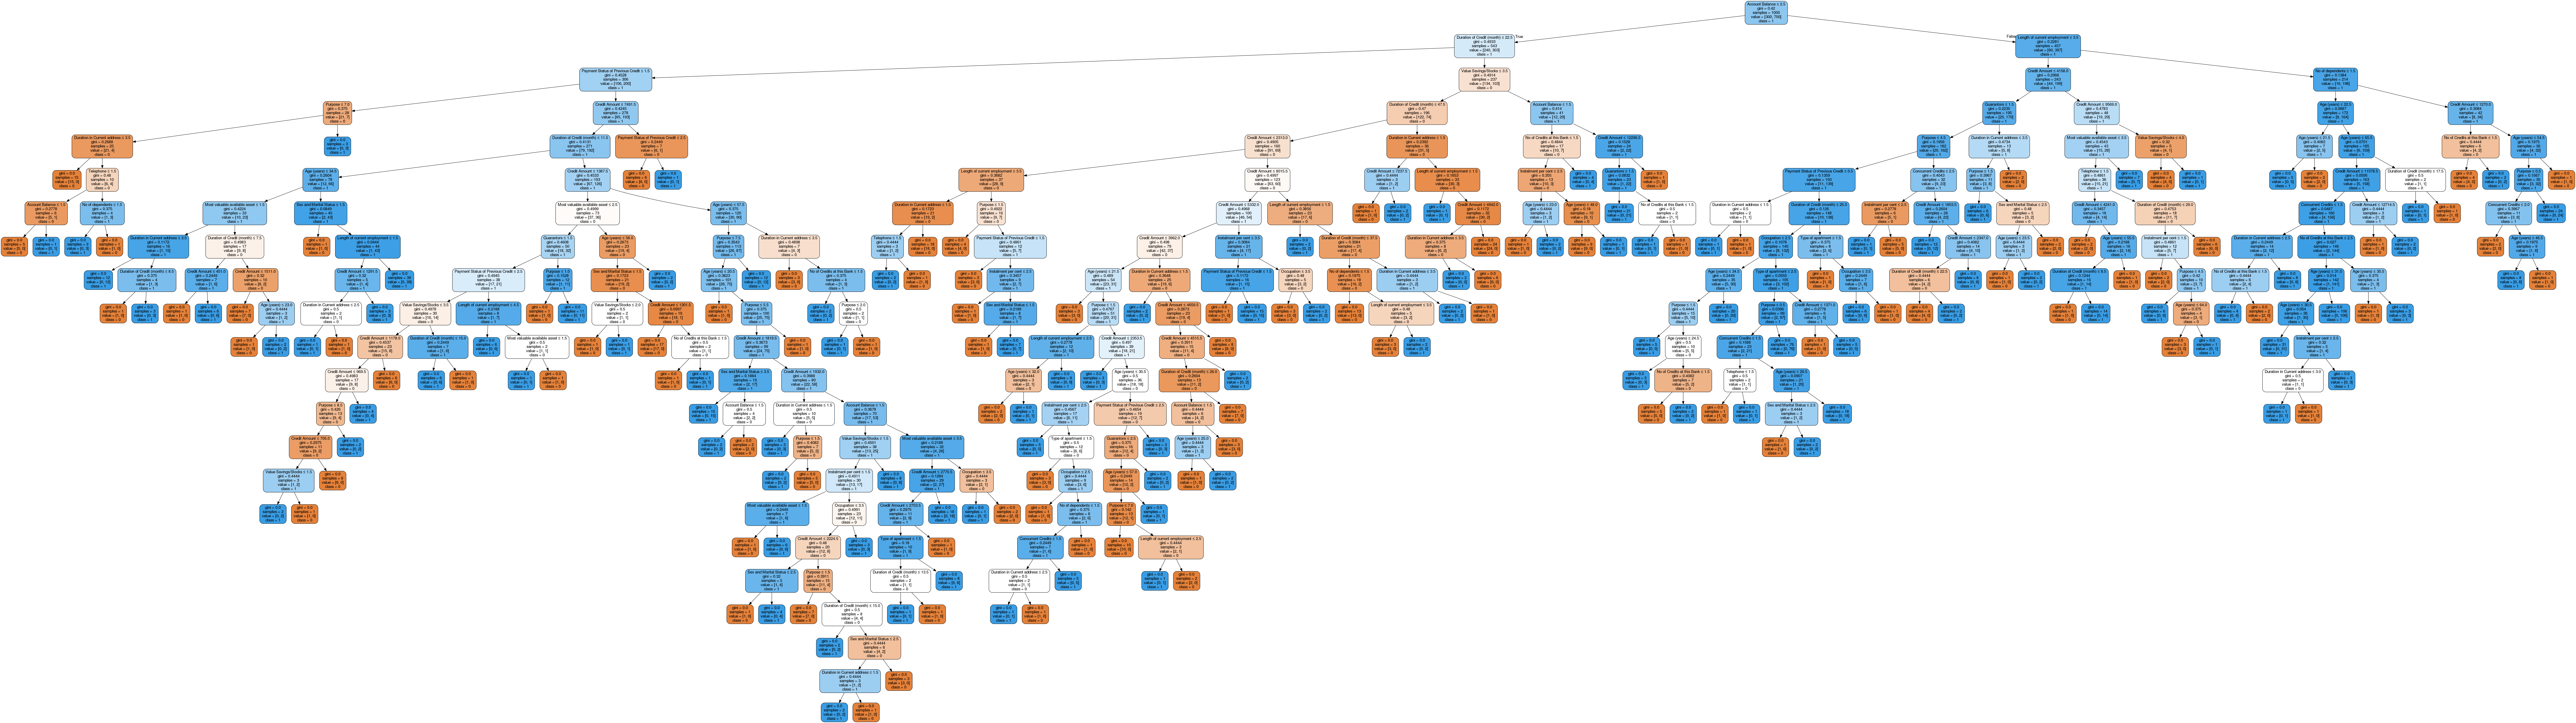

In [9]:
model = tree.DecisionTreeClassifier()
model.fit(german_data, german_target)

dot_data = tree.export_graphviz(model, out_file="big_tree.out", 
                         feature_names=german_data.columns,  
                         class_names=['0', '1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = pydotplus.graphviz.graph_from_dot_file("big_tree.out")
Image(graph.create_png())

In [10]:
train_data, test_data, train_target, test_target = train_test_split(german_data, german_target,
                                                                   test_size = 0.2)

In [11]:
model.fit(train_data, train_target)

test_predictions = model.predict(test_data)

print(roc_auc_score(test_target, test_predictions))

train_predictions = model.predict(train_data)

print(roc_auc_score(train_target, train_predictions))

0.684573652553
1.0


Заметим, что качество на треннировочных данных завышенно, если дерево обучалось на этих же данных.

In [12]:
print(classification_report(test_target, test_predictions))

             precision    recall  f1-score   support

          0       0.53      0.61      0.56        61
          1       0.82      0.76      0.79       139

avg / total       0.73      0.71      0.72       200



In [13]:
np.mean(cross_val_score(model, german_data, german_target, cv=5))

0.67299999999999993

Посмотрим на зависимость площади под ROC-кривой от максимальной глубины дерева.

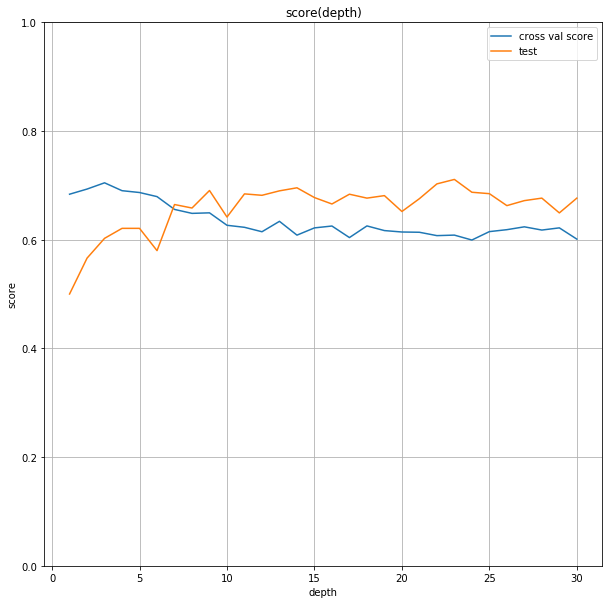

In [14]:
def f_cv(i):
    model = tree.DecisionTreeClassifier(max_depth=i)
    return np.mean(cross_val_score(model, german_data, german_target, cv=5, scoring='roc_auc'))

def f_test(i):
    model = tree.DecisionTreeClassifier(max_depth=i)
    model.fit(train_data, train_target)
    test_predictions = model.predict(test_data)
    return roc_auc_score(test_target, test_predictions)

def f_train(i):
    model = tree.DecisionTreeClassifier(max_depth=i)
    model.fit(train_data, train_target)
    return roc_auc_score(test_target, test_predictions)

plt.figure(figsize=(10, 10))
plt.title('score(depth)')

plt.grid(True)
plt.ylim((0.0, 1.0))
plt.plot([i for i in range(1, 31)], [i for i in map(f_cv, range(1, 31))], label='cross val score')
plt.plot([i for i in range(1, 31)], [i for i in map(f_test, range(1, 31))], label='test')
plt.xlabel('depth')
plt.ylabel('score')
plt.legend(loc='best')
plt.show()

# pylab.legend(loc='lower right')